In [1]:
import json 
import numpy as np 
import torch
from tqdm.notebook import tqdm 

from fugw_solver.solver import solver

# from collections import defaultdict
# data = defaultdict(list)
# with open("dataset/full.jsonl", 'r') as file:
#     for line in file:
#         j = json.loads(line)
#         for k,v in j.items():
#             data[k].append(v)

# with open("dataset/mutag.json", 'w') as f:
#     json.dump(data, f)

with open("dataset/mutag.json", 'r') as f:
    data = json.load(f)

In [2]:
### Hyperparameter
k = 10

In [3]:
features = data["node_feat"]
n = len(features)
y = data["y"]
adjacencies = []
for (sources, targets), num_nodes in zip(data["edge_index"], data["num_nodes"]):
    adj = np.zeros((num_nodes, num_nodes))
    adj[sources, targets] = 1
    adjacencies.append(adj)

In [30]:
# Test
source_features = torch.tensor(features[0]).T.float()
target_features = torch.tensor(features[1]).T.float()
source_geometry = torch.tensor(adjacencies[0]).float()
target_geometry = torch.tensor(adjacencies[1]).float()
P, loss_ls = solver(source_features, target_features, source_geometry, target_geometry, nits_uot=200, nits_bcd=15)

In [31]:
loss_ls[-1]["total"]

0.11042097210884094

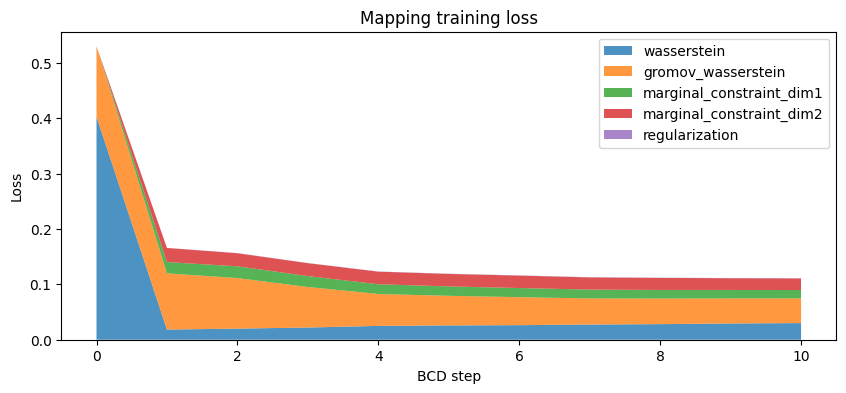

In [10]:
import matplotlib.pyplot as plt
from collections import defaultdict
alpha = 0.5
rho = 1
eps = 1e-4
loss = defaultdict(list)
for l in loss_ls:
    for k,v in l.items():
        loss[k].append(v)
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title("Mapping training loss")
ax.set_ylabel("Loss")
ax.set_xlabel("BCD step")
ax.stackplot(
    np.arange(len(loss_ls)),
    [
        (1 - alpha) * np.array(loss["wasserstein"]),
        alpha * np.array(loss["gromov_wasserstein"]),
        rho * np.array(loss["marginal_constraint_dim1"]),
        rho * np.array(loss["marginal_constraint_dim2"]),
        eps * np.array(loss["regularization"]),
    ],
    labels=[
        "wasserstein",
        "gromov_wasserstein",
        "marginal_constraint_dim1",
        "marginal_constraint_dim2",
        "regularization",
    ],
    alpha=0.8,
)
ax.legend()
plt.show()

In [41]:
def predict(i : int, k:int):
    """Predicts the class of the i-th molecule using a k-NN"""
    source_features = torch.tensor(features[i]).T.float()
    source_geometry = torch.tensor(adjacencies[i]).float()
    distances = []
    for j, (target_features, target_geometry, classif) in enumerate(zip(features, adjacencies, y)):
        if j == i:
            continue
        target_features = torch.tensor(target_features).T.float()
        target_geometry = torch.tensor(target_geometry).float()
        P, loss_ls = solver(source_features, target_features, source_geometry, target_geometry)
        distances.append((loss_ls[-1]["total"], classif))

    distances.sort(key=lambda x: x[0])[:k]
    classes = list(map(lambda x: x[1], distances))

    return 1 if classes.sum() >= classes.len() / 2 else 0

In [37]:
accuracy = 0
for i in tqdm(range(n)):
    prediction = predict(i, k)
    accuracy += (predict == y[i])
accuracy / n

  0%|          | 0/188 [00:00<?, ?it/s]

[(0.06419955939054489, [1]), (0.06487367302179337, [1]), (0.06515702605247498, [0]), (0.06634815782308578, [1]), (0.0664997473359108, [1]), (0.06671404838562012, [1]), (0.06969169527292252, [1]), (0.07133197784423828, [0]), (0.0724690854549408, [1]), (0.07282775640487671, [1]), (0.07407000660896301, [1]), (0.07407359778881073, [0]), (0.07420247048139572, [1]), (0.07486270368099213, [1]), (0.07560259848833084, [1]), (0.07593537867069244, [1]), (0.07616717368364334, [1]), (0.07617349177598953, [1]), (0.07649390399456024, [1]), (0.07736552506685257, [1]), (0.07776779681444168, [1]), (0.08406314998865128, [0]), (0.08515909314155579, [1]), (0.08553212881088257, [0]), (0.08859428018331528, [1]), (0.08919382095336914, [1]), (0.09020604938268661, [1]), (0.09183632582426071, [1]), (0.09422758221626282, [0]), (0.09580327570438385, [0]), (0.09617015719413757, [0]), (0.09663026034832001, [1]), (0.09749879688024521, [1]), (0.09752039611339569, [1]), (0.09753091633319855, [1]), (0.09803937375545502,